In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
from os.path import join
from transformers import T5Tokenizer, T5EncoderModel

In [7]:
!ls $STORE_DIR"/DL_Projects/PixArt/output/pretrained_models/t5_ckpts"

t5-v1_1-xxl


In [2]:
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
encoder = T5EncoderModel.from_pretrained(T5_path, )#subfolder="text_encoder")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache

'blue square is to the right of red circle_32token.pth'
'circle is below red square_32token.pth'
'red circle is above square_32token.pth'
'red circle is to the left of blue square_32token.pth'
'triangle is above and to the right of square_32token.pth'
'triangle is above red circle_32token.pth'
'triangle is to the left of square_32token.pth'
'triangle is to the upper left of square_32token.pth'
 uncond_32token.pth


### Pre making the embedding vectors

In [19]:
@torch.no_grad()
def save_prompt_embeddings(validation_prompts, prompt_cache_dir="output/tmp/prompt_cache", 
                           device="cuda", max_length=24, t5_path=None):
    """Save T5 text embeddings for a list of prompts to cache directory.
    
    Args:
        validation_prompts (list): List of text prompts to encode
        prompt_cache_dir (str): Directory to save embeddings
        device (str): Device to run encoding on
        max_length (int): Max sequence length for tokenization
        t5_path (str): Path to T5 model. If None, uses default path
    """
    if t5_path is None:
        t5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
    
    result_col = []
    os.makedirs(prompt_cache_dir, exist_ok=True)
    # Load models
    print(f"Loading text encoder and tokenizer from {t5_path} ...")
    tokenizer = T5Tokenizer.from_pretrained(t5_path)
    text_encoder = T5EncoderModel.from_pretrained(t5_path).to(device)
    # Save unconditioned embedding
    uncond = tokenizer("", max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
    uncond_prompt_embeds = text_encoder(uncond.input_ids, attention_mask=uncond.attention_mask)[0]
    torch.save({'caption_embeds': uncond_prompt_embeds, 'emb_mask': uncond.attention_mask, 'prompt': ''}, 
               join(prompt_cache_dir,f'uncond_{max_length}token.pth'))
    result_col.append({'prompt': '', 'caption_embeds': uncond_prompt_embeds, 'emb_mask': uncond.attention_mask})
    print("Preparing Visualization prompt embeddings...")
    print(f"Saving visualizate prompt text embedding at {prompt_cache_dir}")
    for prompt in validation_prompts:
        if os.path.exists(join(prompt_cache_dir,f'{prompt}_{max_length}token.pth')):
            result_col.append(torch.load(join(prompt_cache_dir,f'{prompt}_{max_length}token.pth')))
            continue
        print(f"Mapping {prompt}...")
        caption_token = tokenizer(prompt, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
        caption_emb = text_encoder(caption_token.input_ids, attention_mask=caption_token.attention_mask)[0]
        torch.save({'caption_embeds': caption_emb, 'emb_mask': caption_token.attention_mask, 'prompt': prompt}, 
                    join(prompt_cache_dir,f'{prompt}_{max_length}token.pth'))
        result_col.append({'prompt': prompt, 'caption_embeds': caption_emb, 'emb_mask': caption_token.attention_mask})
    print("Done!")
    # garbage collection
    del tokenizer, text_encoder
    torch.cuda.empty_cache()
    return result_col


In [14]:

prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache"

In [33]:
# visualize prompts 
visualize_prompts = [
    "triangle is to the upper left of square", 
    "blue triangle is to the upper left of red square", 
    "triangle is above and to the right of square", 
    "blue circle is above and to the right of blue square", 
    "triangle is to the left of square", 
    "triangle is to the left of triangle", 
    "circle is below red square",
    "red circle is to the left of blue square",
    "blue square is to the right of red circle",
    "red circle is above square",
    "triangle is above red circle",
]
prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache"
caption_embeddings = save_prompt_embeddings(visualize_prompts, prompt_cache_dir, device="cuda", max_length=20, t5_path=T5_path)
for i, embedding in enumerate(caption_embeddings):
    print(f"{i}: {embedding['prompt']} | token num:{embedding['emb_mask'].sum()}")
torch.save(caption_embeddings, join(prompt_cache_dir, "caption_embeddings_list.pth"))

Loading text encoder and tokenizer from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing Visualization prompt embeddings...
Saving visualizate prompt text embedding at /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache
Mapping triangle is to the upper left of square...
Mapping blue triangle is to the upper left of red square...
Mapping triangle is above and to the right of square...
Mapping blue circle is above and to the right of blue square...
Mapping triangle is to the left of square...
Mapping triangle is to the left of triangle...
Mapping circle is below red square...
Mapping red circle is to the left of blue square...
Mapping blue square is to the right of red circle...
Mapping red circle is above square...
Mapping triangle is above red circle...
Done!
0:  | token num:1
1: triangle is to the upper left of square | token num:9
2: blue triangle is to the upper left of red square | token num:11
3: triangle is above and to the right of square | token num:10
4: blue circle is above and to the right of blue square | 

### Generation with pre-make embeddings

In [1]:
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/utils")
from pixart_utils import convert_checkpoint_to_diffusers_transformer, state_dict_convert
from image_utils import pil_images_to_grid

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [12]:
from diffusers import PixArtAlphaPipeline
@torch.inference_mode()
def visualize_prompts(pipeline, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=25, device="cuda"):
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    generator = torch.Generator(device=device).manual_seed(0)
    validation_prompts = [
        "triangle is to the upper left of square", 
        "blue triangle is to the upper left of red square", 
        "triangle is above and to the right of square", 
        "blue circle is above and to the right of blue square", 
        "triangle is to the left of square", 
        "triangle is to the left of triangle", 
        "circle is below red square",
        "red circle is to the left of blue square",
        "blue square is to the right of red circle",
        "red circle is above square",
        "triangle is above red circle",
    ]
    image_logs = []
    images = []
    latents = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    for _, prompt in enumerate(validation_prompts):
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        latents.append(pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            output_type="latent",
        ).images)
    # flush()
    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    for prompt, image in zip(validation_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})

    return image_logs

# pipeline = PixArtAlphaPipeline.from_pretrained(
#         pipeline_path,
#         transformer=model,
#         tokenizer=None,
#         text_encoder=None,
#         torch_dtype=weight_dtype,
#     )


# for tracker in accelerator.trackers:
#     if tracker.name == "tensorboard":
#         for log in image_logs:
#             images = log["images"]
#             validation_prompt = log["validation_prompt"]
#             formatted_images = []
#             for image in images:
#                 formatted_images.append(np.asarray(image))
#             formatted_images = np.stack(formatted_images)
#             tracker.writer.add_images(validation_prompt, formatted_images, step, dataformats="NHWC")

In [5]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_DiT_B_pilot/output/trained_model/checkpoints

epoch_1000_step_40000.pth  epoch_1600_step_64000.pth  epoch_400_step_16000.pth
epoch_100_step_4000.pth    epoch_1625_step_65000.pth  epoch_425_step_17000.pth
epoch_1025_step_41000.pth  epoch_1650_step_66000.pth  epoch_450_step_18000.pth
epoch_1050_step_42000.pth  epoch_1675_step_67000.pth  epoch_475_step_19000.pth
epoch_1075_step_43000.pth  epoch_1700_step_68000.pth  epoch_500_step_20000.pth
epoch_1100_step_44000.pth  epoch_1725_step_69000.pth  epoch_50_step_2000.pth
epoch_1125_step_45000.pth  epoch_1750_step_70000.pth  epoch_525_step_21000.pth
epoch_1150_step_46000.pth  epoch_175_step_7000.pth    epoch_550_step_22000.pth
epoch_1175_step_47000.pth  epoch_1775_step_71000.pth  epoch_575_step_23000.pth
epoch_1200_step_48000.pth  epoch_1800_step_72000.pth  epoch_600_step_24000.pth
epoch_1225_step_49000.pth  epoch_1825_step_73000.pth  epoch_625_step_25000.pth
epoch_1250_step_50000.pth  epoch_1850_step_74000.pth  epoch_650_step_26000.pth
epoch_125_step_5000.pth    epoch_1875_step_75000.pth  

In [4]:
ckpt_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_DiT_B_pilot/output/trained_model/checkpoints/epoch_2000_step_80000.pth"
transformer = convert_checkpoint_to_diffusers_transformer(ckpt_path, model_name="DiT_B-2")

Total number of transformer parameters: 121529120


In [8]:
ckpt_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_DiT_B_pilot/output/trained_model/checkpoints/epoch_375_step_15000.pth"
all_state_dict = torch.load(ckpt_path, )# map_location='cpu'
state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
from diffusers import Transformer2DModel
from diffusers import PixArtAlphaPipeline

# pipeline_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/PixArt-XL-2-512x512"
weight_dtype = torch.float16
pipeline = PixArtAlphaPipeline.from_pretrained(
        "PixArt-alpha/PixArt-XL-2-512x512",
        transformer=transformer,
        tokenizer=None,
        text_encoder=None,
        torch_dtype=weight_dtype,
    )

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
ckpt_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_DiT_B_pilot/output/trained_model/checkpoints/epoch_1575_step_63000.pth"
all_state_dict = torch.load(ckpt_path, )# map_location='cpu'
state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
pipeline.transformer.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache"
image_logs = visualize_prompts(pipeline, prompt_cache_dir, max_length=20, weight_dtype=weight_dtype, device="cuda")

triangle is to the upper left of square


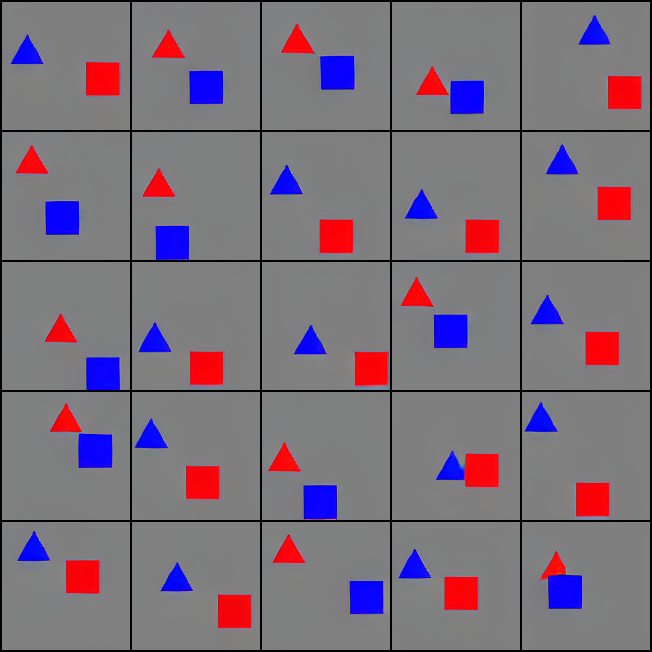

blue triangle is to the upper left of red square


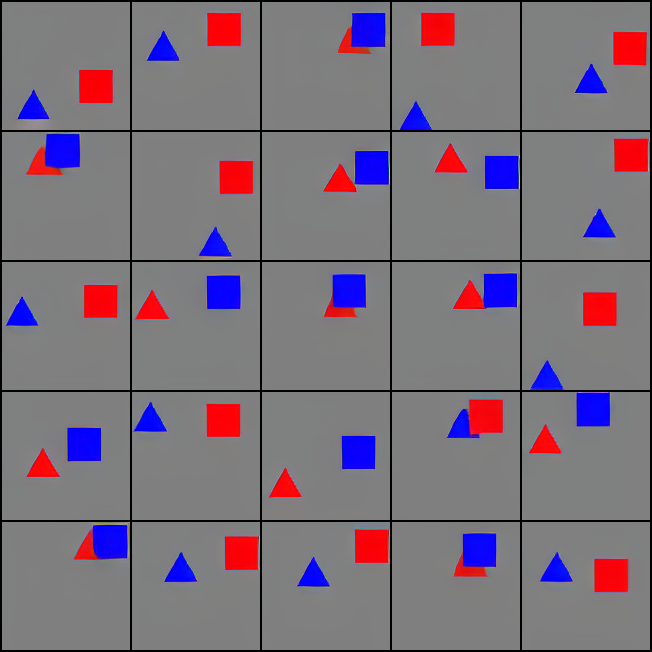

triangle is above and to the right of square


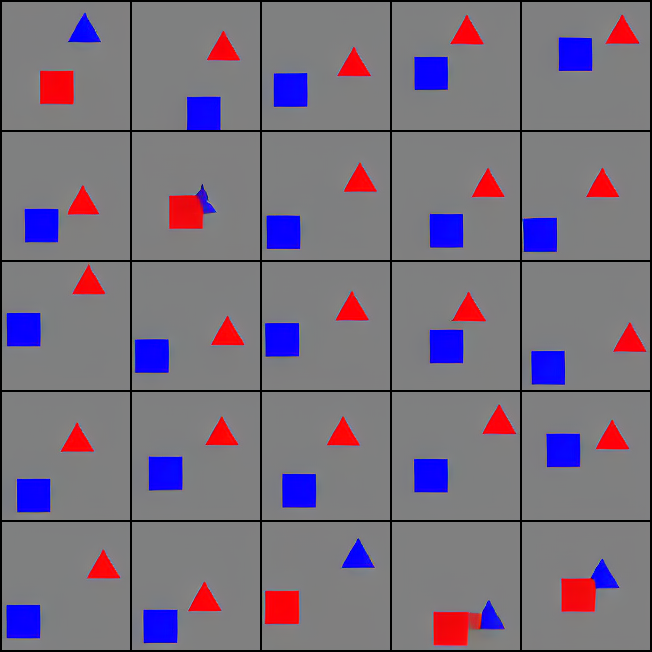

blue circle is above and to the right of blue square


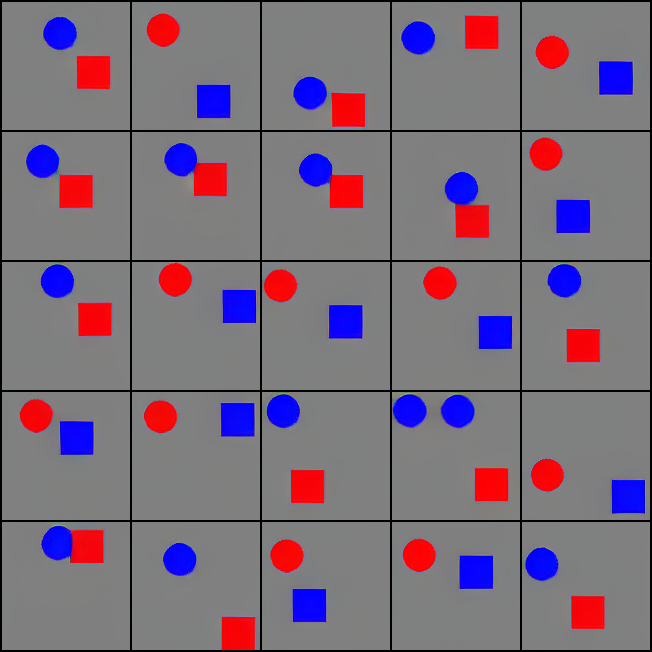

triangle is to the left of square


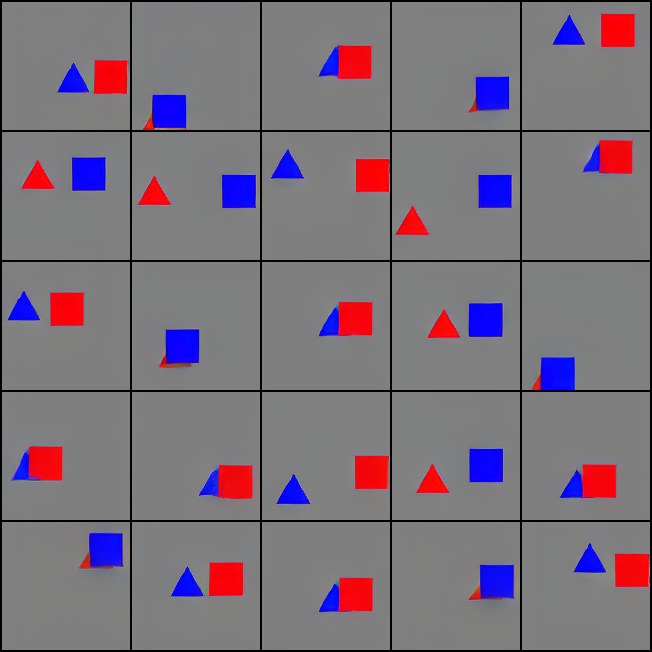

triangle is to the left of triangle


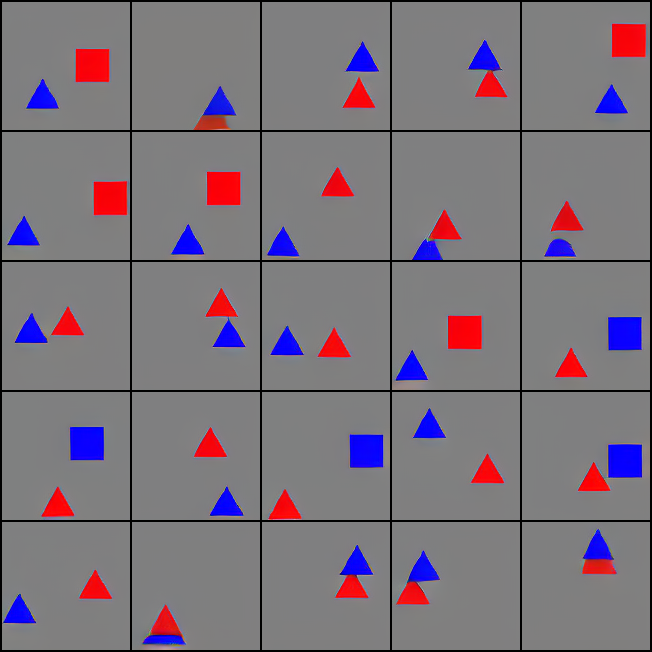

circle is below red square


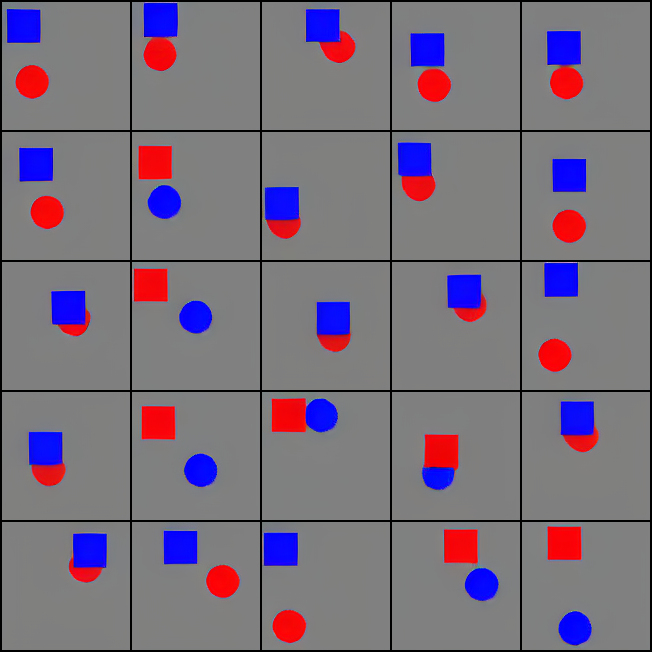

red circle is to the left of blue square


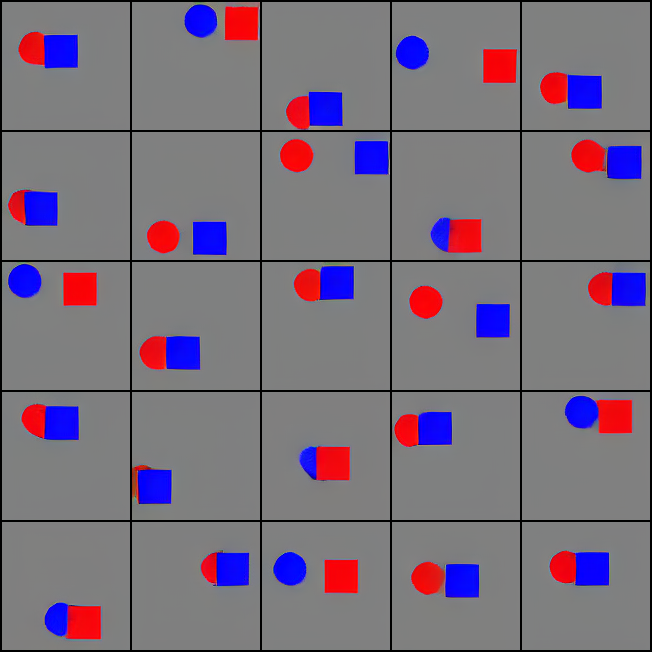

blue square is to the right of red circle


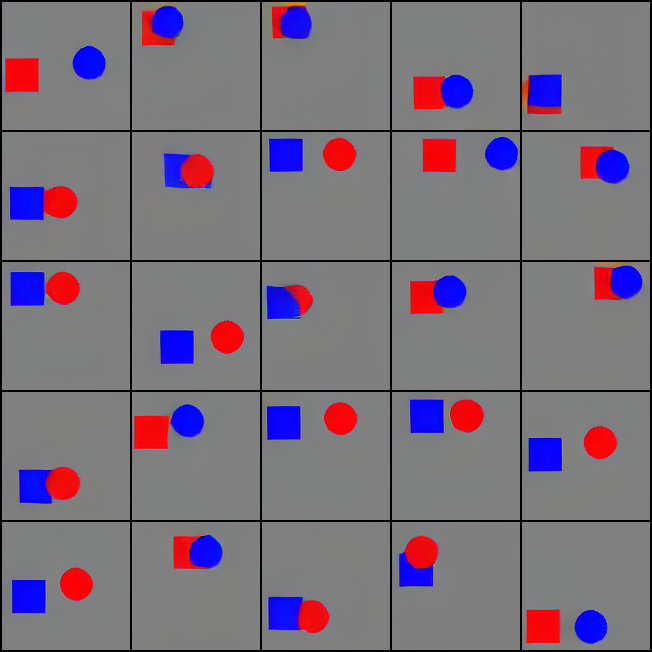

red circle is above square


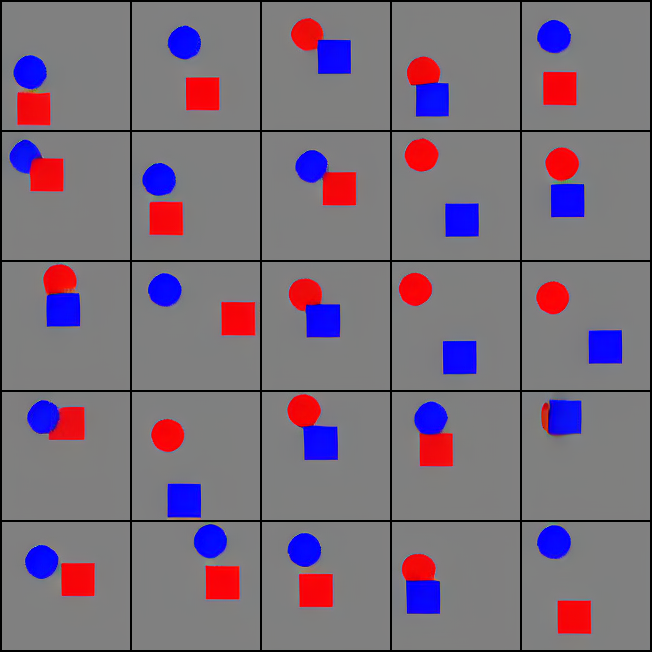

triangle is above red circle


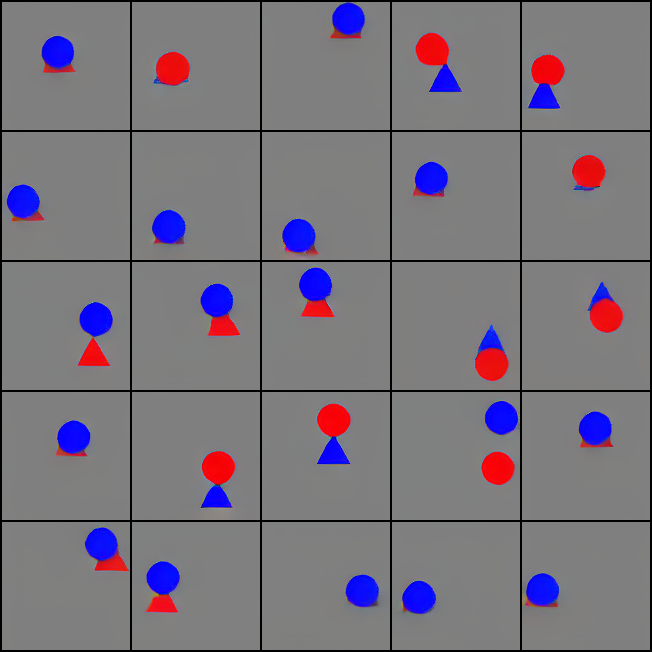

In [16]:
for log in image_logs:
    print(log['validation_prompt'])
    # display(log['images'][0])
    display(pil_images_to_grid(log['images']))


### Development zone

In [18]:
device = "cuda"
max_length = 32
prompt_cache_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache"
os.makedirs(prompt_cache_dir, exist_ok=True)
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(T5_path, ).to(device)#subfolder="text_encoder")



uncond = tokenizer("", max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
uncond_prompt_embeds = text_encoder(uncond.input_ids, attention_mask=uncond.attention_mask)[0]
torch.save({'caption_embeds': uncond_prompt_embeds, 'emb_mask': uncond.attention_mask}, 
           join(prompt_cache_dir,f'uncond_{max_length}token.pth'))

validation_prompts = [
    "triangle is to the upper left of square", 
    "triangle is above and to the right of square", 
    "triangle is to the left of square", 
    "circle is below red square",
    "red circle is to the left of blue square",
    "blue square is to the right of red circle",
    "red circle is above square",
    "triangle is above red circle",
]
print("Preparing Visualization prompt embeddings...")
print(f"Loading text encoder and tokenizer from {T5_path} ...")
skip = True
for prompt in validation_prompts:
    if not os.path.exists(join(prompt_cache_dir,f'{prompt}_{max_length}token.pth')):
        skip = False
        break
# if accelerator.is_main_process and not skip:
print(f"Saving visualizate prompt text embedding at {prompt_cache_dir}")
for prompt in validation_prompts:
    caption_token = tokenizer(prompt, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
    caption_emb = text_encoder(caption_token.input_ids, attention_mask=caption_token.attention_mask)[0]
    torch.save({'caption_embeds': caption_emb, 'emb_mask': caption_token.attention_mask, 'prompt': prompt}, 
               join(prompt_cache_dir,f'{prompt}_{max_length}token.pth'))


Preparing Visualization prompt embeddings...
Loading text encoder and tokenizer from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl ...
Saving visualizate prompt text embedding at /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache


In [20]:
caption_emb.shape, caption_token.attention_mask.shape

(torch.Size([1, 32, 4096]), torch.Size([1, 32]))

In [19]:
caption_token

{'input_ids': tensor([[19938,    19,   756,  1131,  8196,     1,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}

In [17]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/prompt_cache

'blue square is to the right of red circle_32token.pth'
'circle is below red square_32token.pth'
'red circle is above square_32token.pth'
'red circle is to the left of blue square_32token.pth'
'triangle is above and to the right of square_32token.pth'
'triangle is above red circle_32token.pth'
'triangle is to the left of square_32token.pth'
'triangle is to the upper left of square_32token.pth'
 uncond_32token.pth
